# Splitting region stations to train and test stations
In this notebook, the stations of each region are split into training and test stations. The target test ratio is 0.4. Given that entire stations are being assigned to either test or train datasets, the test data ratio is not exactly 0.4 in each region.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
from pathlib import Path
import os
import yaml

In [2]:
# Changing the default directory to the main directory
main_dir_path = Path.cwd().parents[0]
os.chdir(main_dir_path)

In [3]:
# Loading data

# Station definitions
path = 'processed_data/station_definitions.csv'
df = pd.read_csv(path)

# ET0 data
path = 'processed_data/et_data.csv'
et_df = pd.read_csv(path)

# Adding data count column to station definitions dataframe
data_count = et_df.groupby('st_num')['ET0'].count().reset_index().rename(columns={'ET0': 'data_count'})
df = df.merge(data_count, on='st_num')

# Loading shapefiles
path = 'processed_data/map_data/tr_regions_mod.geojson'
tr_geo = gpd.read_file(path, crs='EPSG:4326')

# Creating a Geopandas dataframe for station definitions
df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='EPSG:4326')

### Functions

In [4]:
# Reading the variable abbreviation file
path = 'config_files/variable_abbreviations.yaml'
with open(path, 'r') as f:
    var_abbr_dict = yaml.safe_load(f)['VAR_NAMES']
    

def get_var_abbr(variable_name_list):
    """
    Returns the variable abbreviations of the variables defined in variable_name_list
    """
    
    return [var_abbr_dict.get(x, x) for x in variable_name_list]

In [44]:
def print_region_details(st_data, et_data, name):
    print('{} region:'.format(name))
    
    cond = st_data['region'] == name
    df = st_data.loc[cond].copy()
    
    n_stations = df.shape[0]
    print('    Number of stations: {}'.format(n_stations))
    
    print('    Number of datapoints: {}'.format(df['data_count'].sum()))
    
    cond = et_data['st_num'].isin(df['st_num'])
    et_df = et_data.loc[cond]
    date_range = str(et_data.loc[cond, 'year'].min()) + '-' + str(et_data.loc[cond, 'year'].max())
    print('    Date range: {}'.format(date_range))
    
    print('\n')
    

def plot_map(tr_geo, st_geo, region_name, colors=['skyblue', 'darkorange']):
    """
    Plots the region train and test stations. A column named 'dataset' should be included in the st_geo geodataframe
    which determines if a station is a train or test station.
    """
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Plotting region boundary
    cond = tr_geo['region'] == region_name
    region_geo = tr_geo.loc[cond]
    region_geo.plot(ax=ax, color='white', edgecolor='black')
    
    # Plotting stations
    repl_dict = dict(zip(['train', 'test'], colors))
    color_data = st_geo['dataset'].replace(repl_dict)
    st_geo.plot(ax=ax, color=color_data)
    
    return ax

    
    
def split_data(data, region_name, test_ratio=0.4, plot=True):
    
    # Slicing the defined region
    cond = data['region'] == region_name
    df = data.loc[cond].reset_index(drop=True)
    
    test_size = 0.95 * test_ratio * df['data_count'].sum()
    
    # Series of unique stations in the dataset
    stations = df['st_num'].copy()
    
    st_list = []
    count = 0
    
    while count < test_size:
        st = stations.sample()
        st_list.append(st.squeeze())
        stations = stations.drop(index=st.index)
        
        cond = df['st_num'] == st.squeeze()
        count += df.loc[cond, 'data_count'].squeeze()
    
    cond = df['st_num'].isin(st_list)
    df['dataset'] = 'train'
    df.loc[cond, 'dataset'] = 'test'
    
    print('Total dataset size: {}'.format(df['data_count'].sum()))
    
    cond = df['dataset'] == 'test'
    print('Test dataset size: {}'.format(df.loc[cond, 'data_count'].sum()))
    print('Test dataset ratio: {:.3f}'.format(float(df.loc[cond, 'data_count'].sum()/df['data_count'].sum())))
    print('\n')
    print('Total number of stations: {}'.format(df.shape[0]))
    print('Number of stations in test dataset: {}'.format(cond.sum()))
    
    if plot == True:
        ax = plot_map(tr_geo, df, region_name)
        ax.set_title(f'{region_name} region')
        plt.show()
        
    return df
    
    
def train_test_dist(ax, train_data, test_data, var, bins, title, alpha, colors):
    all_data = pd.concat([train_data, test_data]).sort_values(by = ['st_num', 'year', 'month'])
    count, edges = np.histogram(all_data[var], bins = bins)
    labels = list(map(lambda x: '{:.1f}'.format(x), edges))
    
    # All Data
    ax.hist(all_data[var], bins = edges, edgecolor = 'w', alpha = alpha, color = colors[0], label = 'All')
    
    # Training Data
    ax.hist(train_data[var], bins = edges, edgecolor = 'w', alpha = alpha, color = colors[1], label = 'Training')
    
    # Test Data
    ax.hist(test_data[var], bins = edges, edgecolor = 'w', alpha = alpha, color = colors[2], label = 'Test')
    
    ax.set_xticks(ticks = edges)
    ax.set_xticklabels(labels, rotation = 'vertical')
    ax.set_title(title)
    ax.legend()
    
    
def get_train_test(st_data, et_data, region_name):
    """
    Get train and test data for the defined region.
    The dataset of each station should be defined in st_data['dataset'].
    """
    
    # Slicing region_data
    if region_name is not None:
        cond = st_data['region'] == region_name
        st_df = st_data.loc[cond].reset_index(drop=True)
    else:
        st_df = st_data.copy()
    
    cond = st_df['dataset'] == 'test'
    test_stations = st_df.loc[cond, 'st_num']
    train_stations = st_df.loc[~cond, 'st_num']
    
    cond = et_df['st_num'].isin(test_stations)
    test_data = et_df.loc[cond]
    
    cond = et_df['st_num'].isin(train_stations) 
    train_data = et_df.loc[cond]
    
    return (train_data, test_data)



def plot_split_distributions(st_data, et_data, region_name, figsize = (14, 14)):
    
    train_data, test_data = get_train_test(st_data, et_data, region_name)
    
    fig, axs = plt.subplots(3, 2, constrained_layout = True, figsize = (14, 14))
    
    if region_name is None:
        region_name = 'Combined Dataset'
    fig.suptitle('{} Training and Test Data Distributions\n'.format(region_name.capitalize()), fontsize = 20)
    axs = axs.flatten()
    
    var_name_list = ['minimum_temperature', 'maximum_temperature', 'maximum_relative_humidity',
                     'average_wind_speed', 'average_solar_radiation', 'ET0']
    
    var_list = get_var_abbr(var_name_list)
    
    bins = 25
    titles = ['Minimum Temperature', 'Maximum Temperature', 'Maximum Humidity',
              'Wind Speed', 'Solar Radiation', 'FAO-56 PM ET0']

    alpha = 0.6
    colors = ['grey', 'black', '#1c6fff']
    for i, var in enumerate(var_list):
        train_test_dist(axs[i], train_data, test_data, var, bins, titles[i], alpha, colors)

    plt.show()

    
def print_split_details(st_data,
                        et_data,
                        region_name,
                        features = ['year', 'elevation', 'minimum_temperature',
                                    'maximum_temperature', 'average_temperature',
                                    'maximum_relative_humidity', 'minimum_relative_humidity',
                                    'average_wind_speed', 'average_solar_radiation', 'Ra', 'ET0']):
    
    features = get_var_abbr(features)
    
    train_data, test_data = get_train_test(st_data, et_data, region_name)
    
    data_prop = pd.DataFrame(columns = ['feature', 'train_test', 'min', 'max', 'mean', 'std'])\
        .set_index(['feature', 'train_test'])

    function_dict = dict(zip(
    ['min', 'max', 'mean', 'std'],
    [np.min, np.max, np.mean, np.std]))

    for feature in features:
        for col in data_prop.columns:
            data_prop.loc[(feature, 'train'), col] = function_dict[col](train_data[feature])
            data_prop.loc[(feature, 'test'), col] = function_dict[col](test_data[feature])
    return data_prop

In [6]:
region_names = ['Black Sea', 'Marmara', 'Central Anatolia', 'Eastern Anatolia',
       'Aegean', 'Southeastern Anatolia', 'Mediterranean']

In [7]:
for name in region_names:
    print_region_details(df, et_df, name)

Black Sea region:
    Number of stations: 20
    Number of datapoints: 4488
    Date range: 1968-2020


Marmara region:
    Number of stations: 28
    Number of datapoints: 6012
    Date range: 1967-2020


Central Anatolia region:
    Number of stations: 35
    Number of datapoints: 10020
    Date range: 1967-2020


Eastern Anatolia region:
    Number of stations: 22
    Number of datapoints: 7932
    Date range: 1967-2020


Aegean region:
    Number of stations: 33
    Number of datapoints: 8328
    Date range: 1967-2020


Southeastern Anatolia region:
    Number of stations: 8
    Number of datapoints: 2580
    Date range: 1968-2020


Mediterranean region:
    Number of stations: 19
    Number of datapoints: 5028
    Date range: 1967-2020




## Splitting data
The `split_data` function randomly assigns stations to the test dataset until the datapoints in the test dataset are almost 0.4 of the whole data. Every run of this function will return different results based on which stations were assigned to the test and train datasets. The choice of the split was made by running the function repetitively until achieving a test ratio close to 0.4, uniform spatial distribution of stations in the region, and similar variable distributions in the train and test datasets.

### Mediterranean

In [8]:
region_name = 'Mediterranean'

Splitting procedure

Total dataset size: 5028
Test dataset size: 2040
Test dataset ratio: 0.406


Total number of stations: 19
Number of stations in test dataset: 8


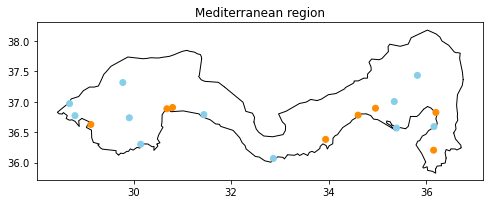

In [12]:
split_result = split_data(df, region_name)

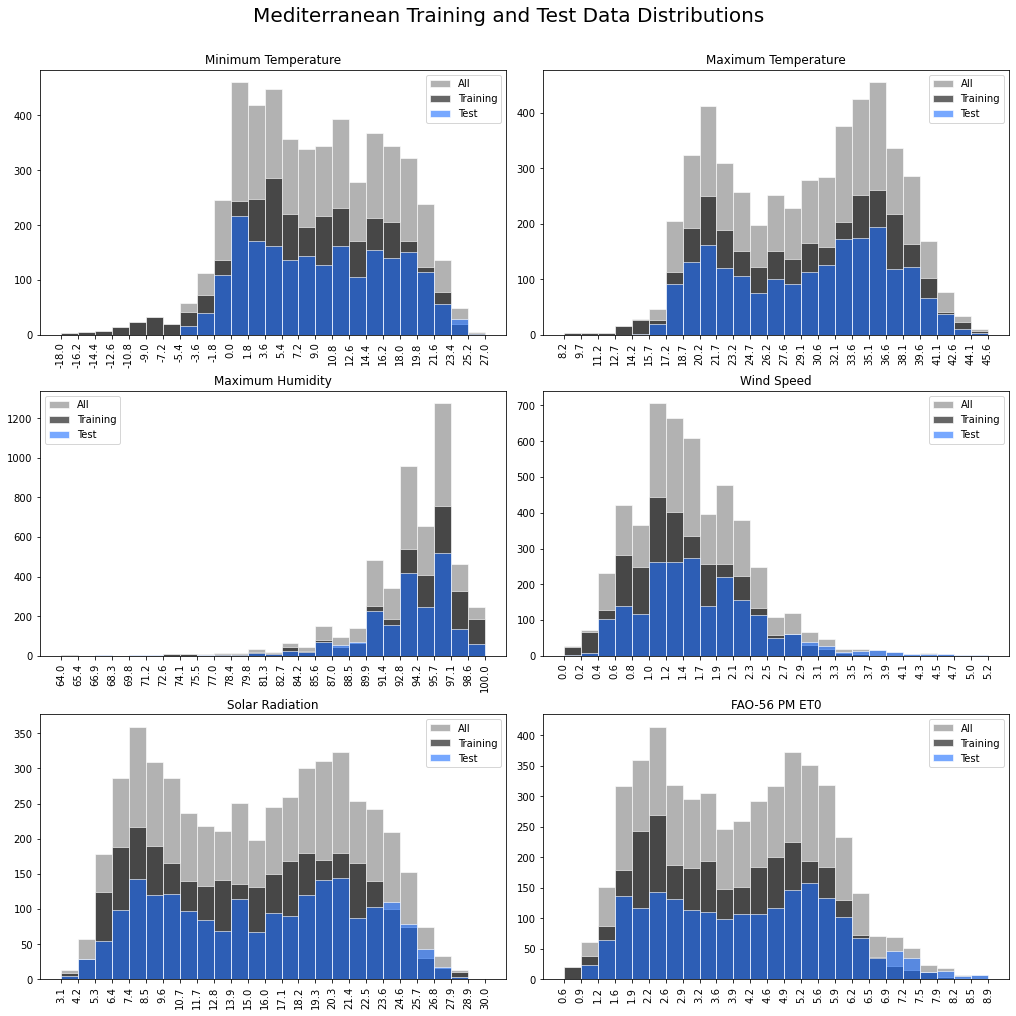

In [13]:
plot_split_distributions(split_result, et_df, region_name)

In [14]:
split_info = print_split_details(split_result, et_df, region_name)
split_info

min        max         mean         std
feature   train_test                                               
year      train            1968       2020  1993.558233   11.230231
          test             1967       2020  1994.270588   10.863201
elevation train             2.0     1142.0   143.630522  351.991671
          test              3.0      104.0    34.976471   36.085838
min_temp  train           -18.0       26.4     8.574665    7.802141
          test             -5.0       27.0     9.649657    7.350223
max_temp  train             8.2       45.6    29.314491    7.384334
          test             14.4       45.0    29.595294    7.070969
avg_temp  train            -2.3      33.65    18.944578    7.279574
          test              5.5       33.3    19.622475    6.931203
max_hum   train            64.0      100.0    93.976908     4.24719
          test             65.0      100.0        93.35    4.107627
min_hum   train             0.0       65.0    24.419009    9.939432
          test              0.0       70.0    25.027451   10.599955
avg_ws    train             0.0   4.338116     1.467591     0.63259
          test          0.14959   5.160862     1.667198    0.755695
avg_rad   train        3.142184  28.861232    15.069544    5.980361
          test         3.267704  30.007648    15.794977    6.160212
Ra        train       15.168055  41.760746    29.381469    9.344082
          test        15.494618  41.734893     29.41157    9.322257
ET0       train        0.561115   8.438041     3.823721    1.564998
          test         0.804777   8.877215     4.119962    1.713505

In [15]:
for _, row in split_result.iterrows():
    station_dataset_dict[row['st_num']] = row['dataset']

### Marmara

In [16]:
region_name = 'Marmara'

Splitting procedure

Total dataset size: 6012
Test dataset size: 2340
Test dataset ratio: 0.389


Total number of stations: 28
Number of stations in test dataset: 9


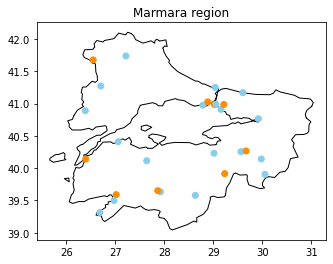

In [17]:
split_result = split_data(df, region_name)

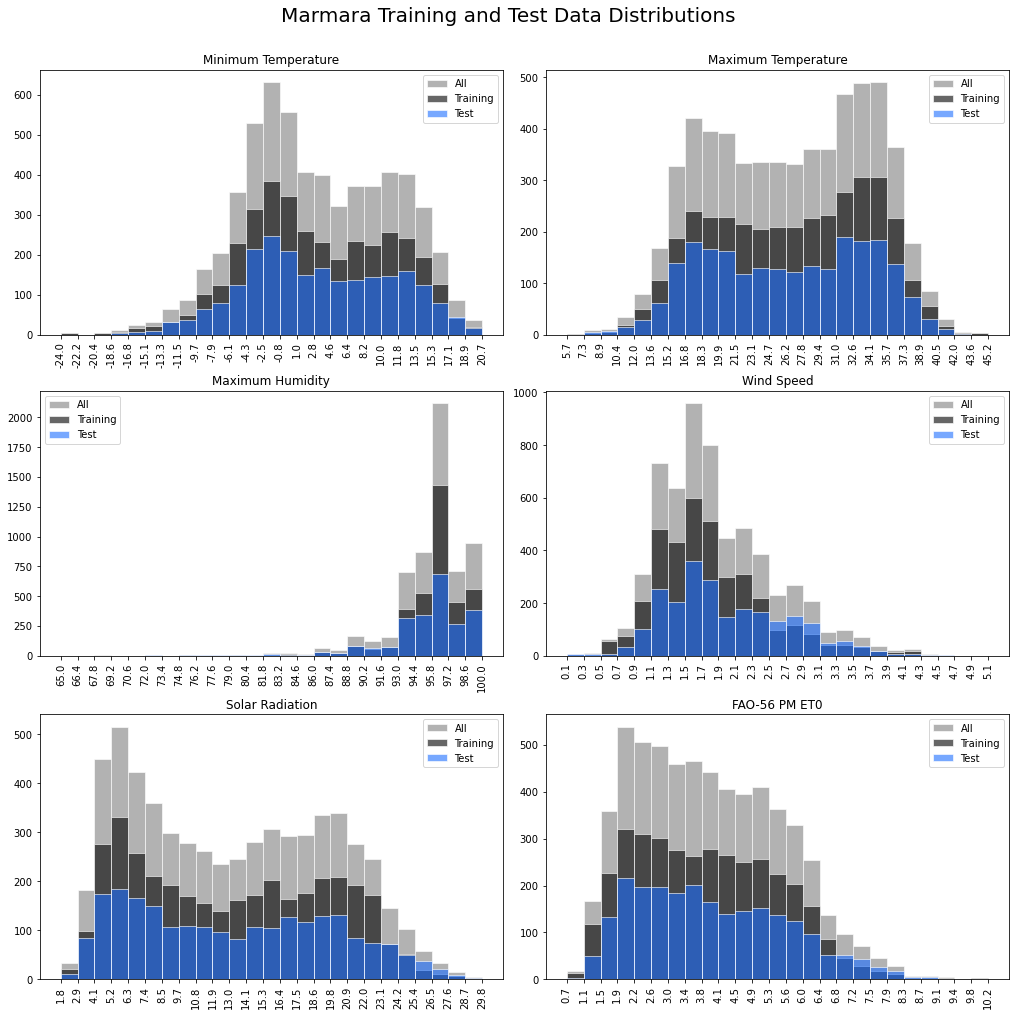

In [18]:
plot_split_distributions(split_result, et_df, region_name)

In [19]:
split_info = print_split_details(split_result, et_df, region_name)
split_info

min        max         mean         std
feature   train_test                                               
year      train            1968       2020       1995.0   11.269718
          test             1967       2020  1992.507692   12.331477
elevation train             4.0      754.0   178.581699  233.500602
          test              5.0     1063.0    157.65641    312.0024
min_temp  train           -24.0       20.7     3.152614    7.745197
          test            -19.0       19.9     3.347436    7.778243
max_temp  train             5.7       45.2    26.749537    7.347526
          test              7.4       42.8    26.348675    7.487235
avg_temp  train           -6.65      29.45    14.951076    7.187998
          test             -4.1       30.1    14.848056    7.333334
max_hum   train            66.0      100.0    95.898965    2.908439
          test             65.0      100.0    95.288462    3.977516
min_hum   train             0.0       79.0    31.593682   11.720043
          test              6.0       76.0    31.502564   11.897011
avg_ws    train         0.29918   5.086067     1.793107    0.657607
          test         0.074795   4.562502     1.982933    0.726632
avg_rad   train        1.824224  29.446992    13.118471    6.350597
          test          2.05016  29.836104    13.308374    6.624183
Ra        train       12.504284  41.883616    28.078469   10.214692
          test        12.542237  41.882924    28.109439   10.195466
ET0       train        0.979434  10.197593     3.868286    1.588917
          test         0.718041   9.234412     3.972264    1.664852

In [20]:
for _, row in split_result.iterrows():
    station_dataset_dict[row['st_num']] = row['dataset']

### Aegean

In [21]:
region_name = 'Aegean'

Splitting procedure

Total dataset size: 8328
Test dataset size: 3276
Test dataset ratio: 0.393


Total number of stations: 33
Number of stations in test dataset: 12


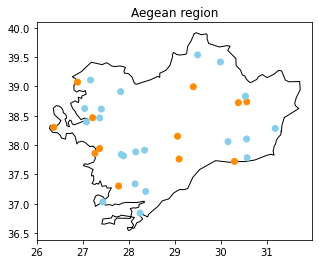

In [22]:
split_result = split_data(df, region_name)

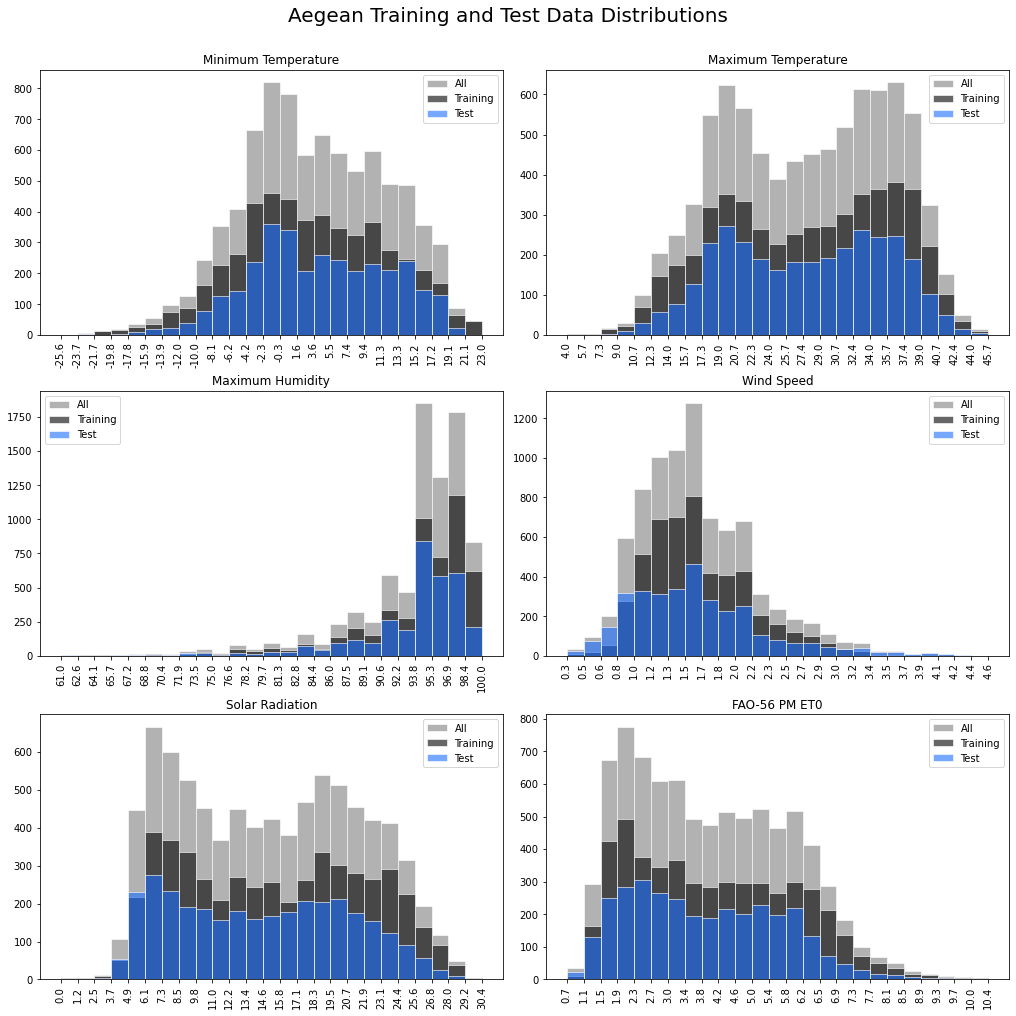

In [23]:
plot_split_distributions(split_result, et_df, region_name)

In [24]:
split_info = print_split_details(split_result, et_df, region_name)
split_info

min        max         mean         std
feature   train_test                                               
year      train            1967       2020  1995.247031    10.95882
          test             1967       2020  1993.278388   10.738115
elevation train            10.0     1096.0   469.014252  422.472464
          test              3.0     1149.0   332.388278  412.612364
min_temp  train           -25.6       23.0     3.438579    8.523326
          test            -22.0       20.3     4.229487    7.920558
max_temp  train             4.0       45.5    27.697605    8.400583
          test              5.0       45.7    27.644261    7.775502
avg_temp  train            -7.6       33.7    15.568092    8.208003
          test            -6.15      31.55    15.936874    7.621892
max_hum   train            62.0      100.0    93.871734    5.490416
          test             61.0      100.0    93.488706    5.318448
min_hum   train             0.0       61.0    23.761876    9.322736
          test              0.0       65.0    26.809219   11.374035
avg_ws    train         0.29918   3.964141     1.629281    0.523352
          test          0.29918   4.562502     1.605972    0.675572
avg_rad   train        0.029288   29.66456    15.458272    6.565984
          test         2.794912    30.4386    14.455903    6.252409
Ra        train       13.864427  41.840051    28.919205    9.666295
          test        14.152205  41.825775    28.833772    9.722467
ET0       train        0.712622  10.434616     4.090639    1.860266
          test          0.73629   10.30237     3.900592    1.711105

In [25]:
for _, row in split_result.iterrows():
    station_dataset_dict[row['st_num']] = row['dataset']

### Central Anatolia

In [26]:
region_name = 'Central Anatolia'

Splitting procedure

Total dataset size: 10020
Test dataset size: 3912
Test dataset ratio: 0.390


Total number of stations: 35
Number of stations in test dataset: 14


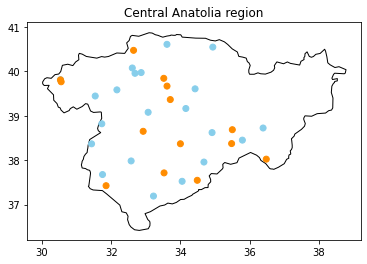

In [27]:
split_result = split_data(df, region_name)

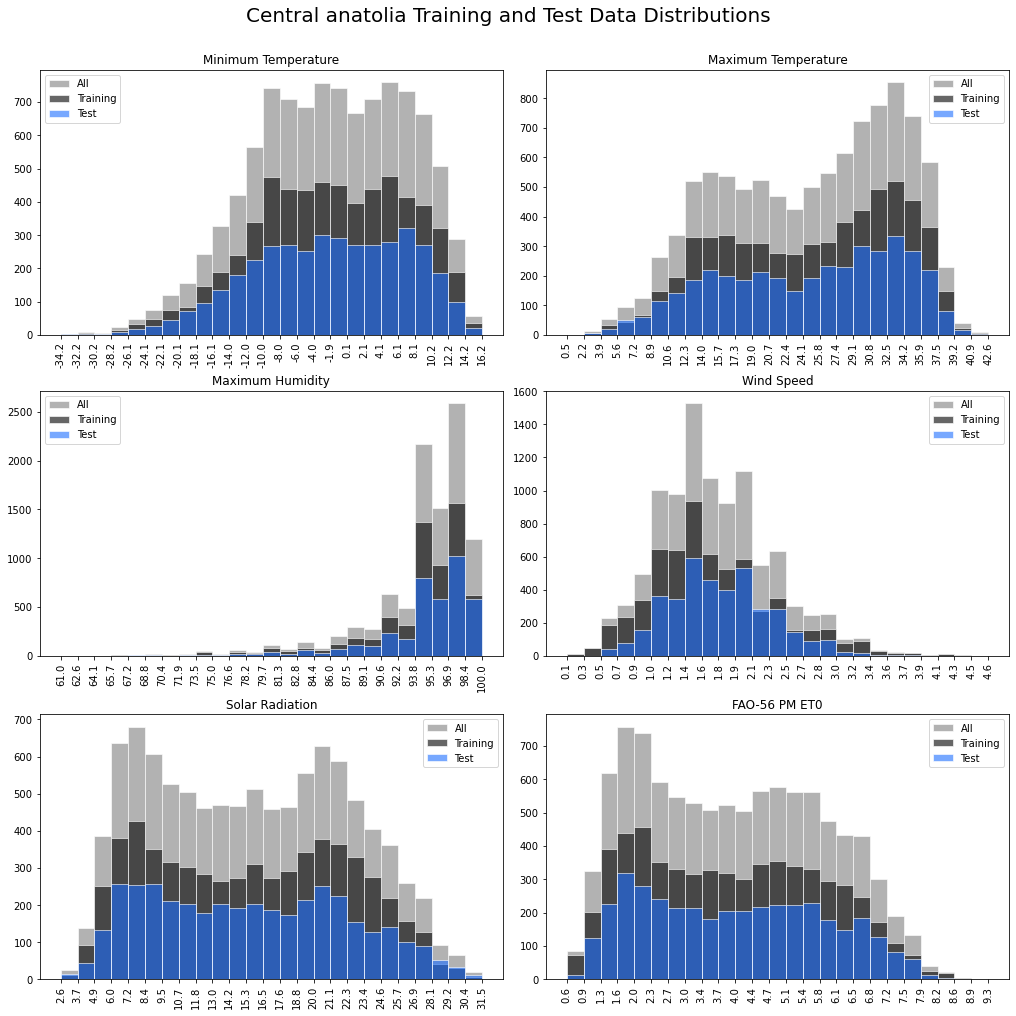

In [28]:
plot_split_distributions(split_result, et_df, region_name)

In [29]:
split_info = print_split_details(split_result, et_df, region_name)
split_info

min        max         mean         std
feature   train_test                                               
year      train            1967       2020  1995.481336   12.059045
          test             1968       2020  1995.217791   11.685492
elevation train           755.0     1542.0   1020.02947  196.094593
          test            751.0     1453.0   1061.45092  160.133598
min_temp  train           -34.2       16.2    -1.924525    9.076805
          test            -33.5       16.1    -2.008742     9.08946
max_temp  train             0.5       42.6    24.963245    8.629908
          test              2.2       41.6    24.628758    8.767077
avg_temp  train           -13.8      27.85     11.51936    8.620111
          test           -13.65       28.3    11.310008    8.702651
max_hum   train            61.0      100.0     94.24869    5.009017
          test             64.0      100.0     94.68047    4.945319
min_hum   train             0.0       64.0    23.307629   11.203767
          test              0.0       73.0    24.255112   11.726142
avg_ws    train         0.14959   4.637297     1.695172    0.653368
          test         0.523566   4.113731     1.774663    0.540709
avg_rad   train         2.57316  31.543099    15.642872     6.63317
          test         2.840936   31.53523    15.606054    6.658107
Ra        train       13.202391  41.866122    28.604943    9.878896
          test        13.286072  41.863342    28.699306     9.81468
ET0       train         0.57155   9.265704     3.964996    1.861198
          test         0.792788    8.62044     4.012857    1.849764

In [30]:
for _, row in split_result.iterrows():
    station_dataset_dict[row['st_num']] = row['dataset']

### Black Sea

In [31]:
region_name = 'Black Sea'

Splitting procedure

Total dataset size: 4488
Test dataset size: 1752
Test dataset ratio: 0.390


Total number of stations: 20
Number of stations in test dataset: 8


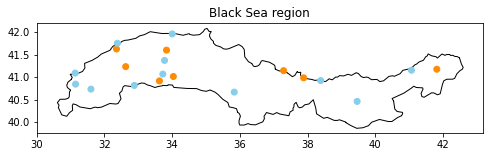

In [32]:
split_result = split_data(df, region_name)

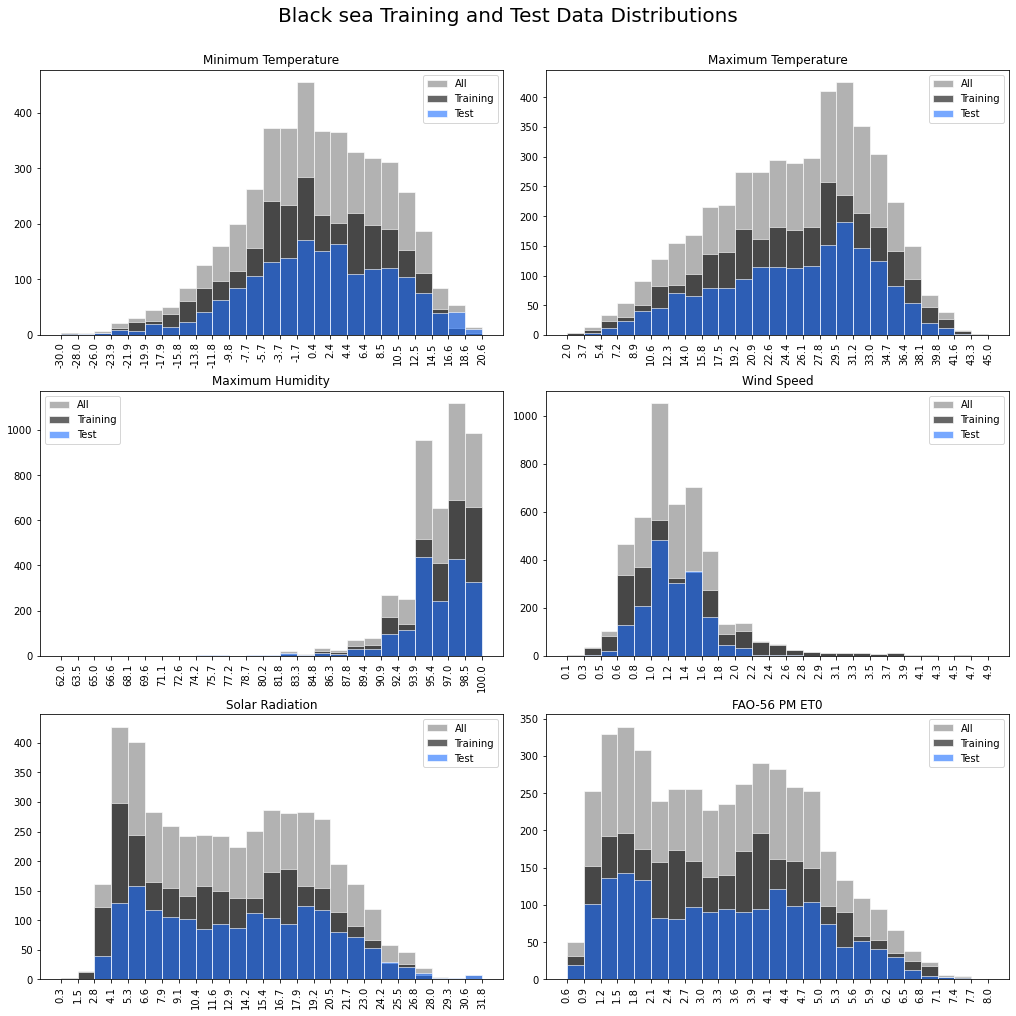

In [33]:
plot_split_distributions(split_result, et_df, region_name)

In [34]:
split_info = print_split_details(split_result, et_df, region_name)
split_info

min        max         mean         std
feature   train_test                                               
year      train            1968       2020  1995.714912   12.860669
          test             1985       2020   1998.39726    8.927777
elevation train            10.0     1890.0   592.017544  454.819831
          test              5.0     1050.0   526.191781  408.198184
min_temp  train           -30.0       19.2     0.194262    8.463501
          test            -28.1       20.6     1.092237     8.66601
max_temp  train             2.0       45.0    25.230811    8.012609
          test              4.6       42.8    25.169349    7.830006
avg_temp  train           -11.5      28.75    12.712537    7.877081
          test            -10.3      28.85    13.130793    7.819424
max_hum   train            62.0      100.0    96.033991    3.159262
          test             75.0      100.0    95.675228    3.410148
min_hum   train             0.0       74.0    30.795322   15.853719
          test              0.0       64.0    29.226027   12.049425
avg_ws    train        0.074795   4.861682     1.338411     0.57421
          test         0.448771   2.617829     1.271602    0.321716
avg_rad   train        0.288696    28.3466    12.584213    6.251038
          test         2.711232  31.813991    13.604587    6.352962
Ra        train       12.367639  41.885864    27.827753    10.37018
          test        12.574269  41.882317    27.793706     10.3902
ET0       train         0.68868   7.988675     3.300514    1.523176
          test         0.598358   7.467791     3.298352    1.558762

In [35]:
for _, row in split_result.iterrows():
    station_dataset_dict[row['st_num']] = row['dataset']

### Eastern Anatolia

In [36]:
region_name = 'Eastern Anatolia'

Splitting procedure

Total dataset size: 7932
Test dataset size: 3204
Test dataset ratio: 0.404


Total number of stations: 22
Number of stations in test dataset: 9


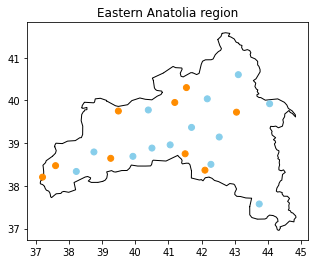

In [37]:
split_result = split_data(df, region_name)

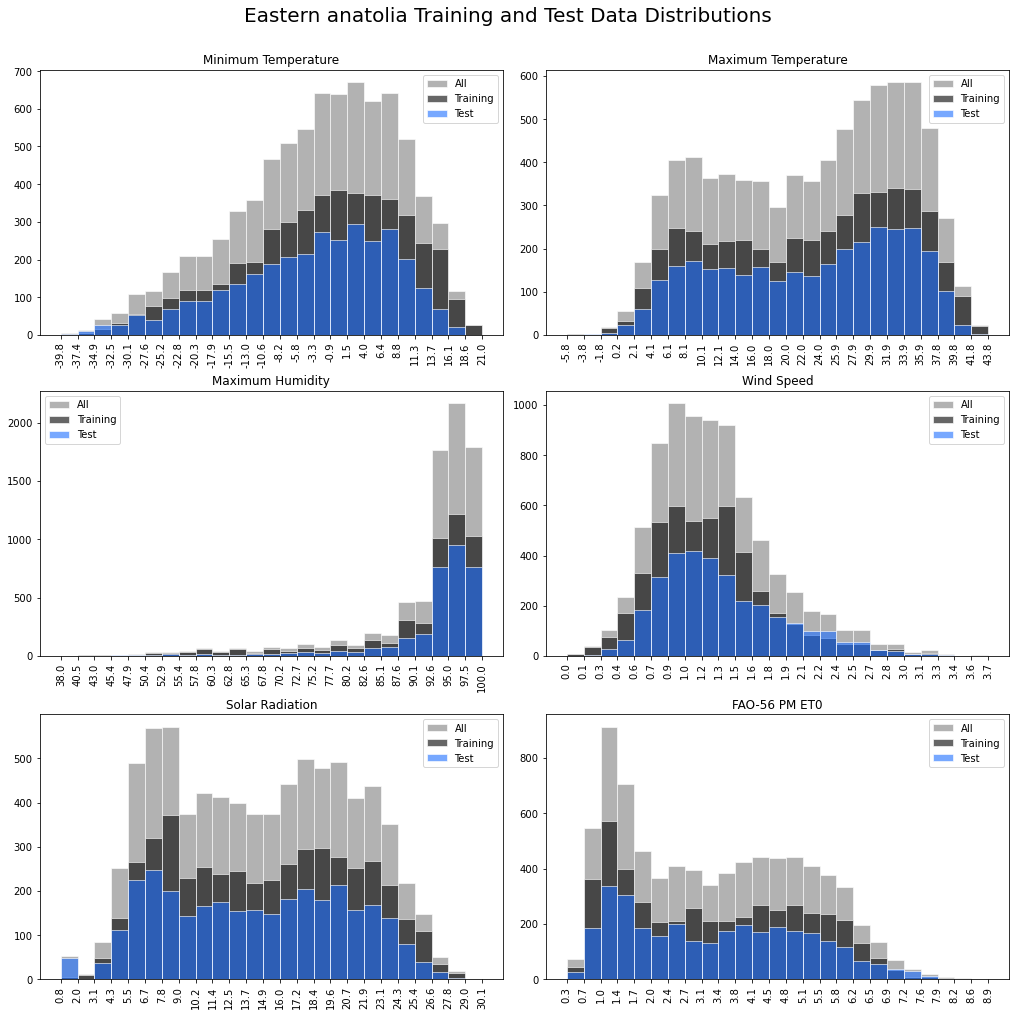

In [38]:
plot_split_distributions(split_result, et_df, region_name)

In [39]:
split_info = print_split_details(split_result, et_df, region_name)
split_info

min        max         mean         std
feature   train_test                                               
year      train            1967       2020  1994.555838   13.001295
          test             1968       2020  1994.970037   11.955561
elevation train           823.0     1777.0  1313.319797  367.059241
          test            989.0     1758.0  1350.973783  270.780083
min_temp  train           -37.9       21.0    -1.927094   11.609563
          test            -39.8       18.5    -3.601841   11.488445
max_temp  train            -5.8       43.8    22.820897   10.930936
          test             -3.0       42.2    22.712422   10.604173
avg_temp  train           -19.5      31.65    10.446901   11.029056
          test            -18.3      29.45      9.55529   10.809351
max_hum   train            38.0      100.0    91.442682   10.254095
          test             45.0      100.0     93.18633    8.322423
min_hum   train             0.0       73.0    24.264171   12.584428
          test              0.0       76.0    26.331461   13.439883
avg_ws    train             0.0   3.590165     1.229832    0.513347
          test          0.14959   3.739755     1.335807    0.542079
avg_rad   train        0.786592  30.133168    14.901944    6.243021
          test         1.209176  29.170848     14.32784    6.304408
Ra        train       13.204865  41.866042    28.554235    9.910592
          test        13.392226  41.859602     28.51003    9.938487
ET0       train        0.321287   8.933667     3.287456    1.829156
          test         0.376238   8.625576      3.35216    1.811022

In [40]:
for _, row in split_result.iterrows():
    station_dataset_dict[row['st_num']] = row['dataset']

### Southeastern Anatolia

In [41]:
region_name = 'Southeastern Anatolia'

Splitting procedure

Total dataset size: 2580
Test dataset size: 1044
Test dataset ratio: 0.405


Total number of stations: 8
Number of stations in test dataset: 3


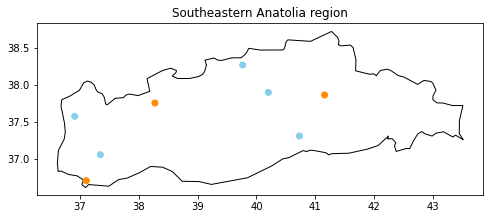

In [42]:
split_result = split_data(df, region_name)

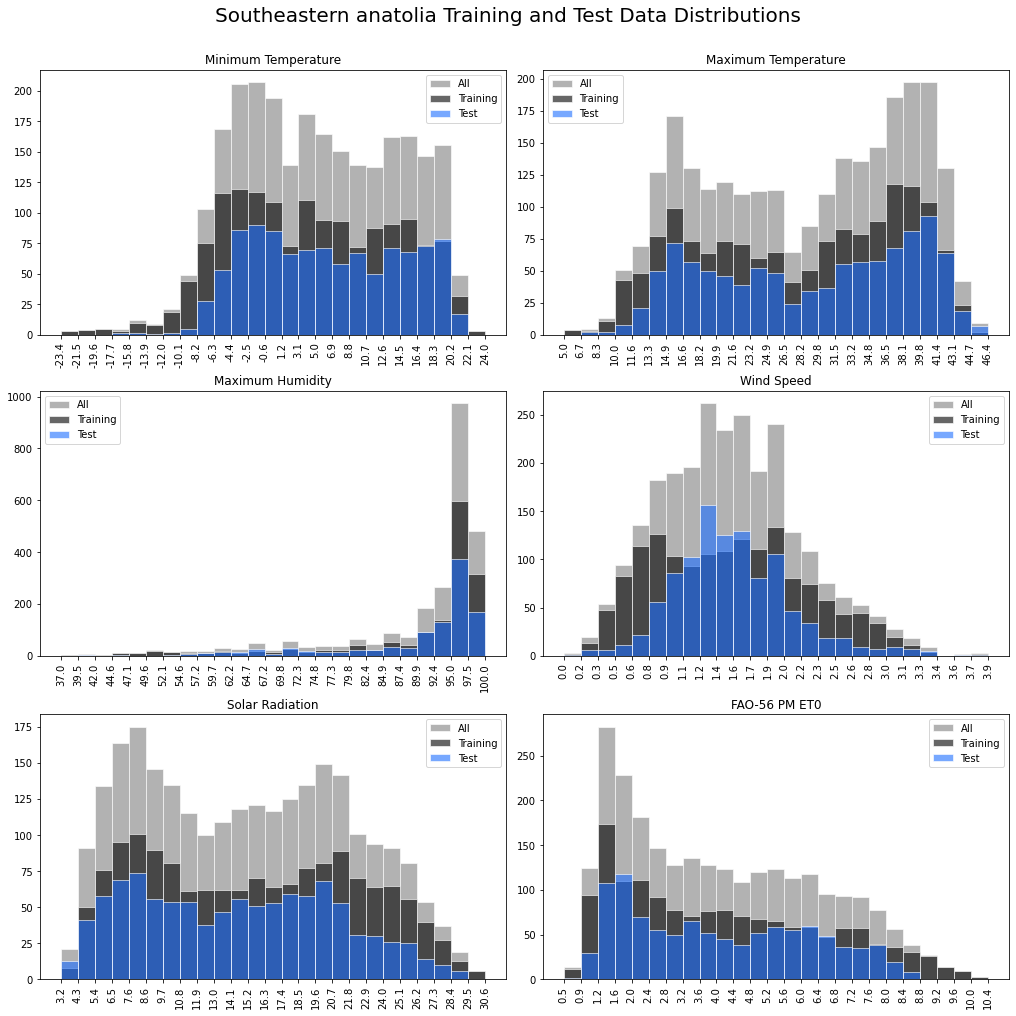

In [43]:
plot_split_distributions(split_result, et_df, region_name)

In [44]:
split_info = print_split_details(split_result, et_df, region_name)
split_info

min        max         mean         std
feature   train_test                                               
year      train            1968       2020       1994.0   12.130154
          test             1968       2020  1994.643678   11.543996
elevation train           572.0     1040.0   796.484375  154.127331
          test            610.0      672.0   648.482759   23.726343
min_temp  train           -23.4       24.0     4.538737    9.190095
          test            -16.6       22.0     6.396648    8.334835
max_temp  train             5.0       45.2    27.970182    9.962547
          test              7.3       46.4    29.049138    9.808957
avg_temp  train            -8.0      33.15     16.25446    9.376792
          test             -1.6       32.5    17.722893    8.900792
max_hum   train            37.0      100.0    90.075521   12.538307
          test             37.0      100.0    89.834291    11.26298
min_hum   train             0.0       60.0    19.733724    9.500072
          test              0.0       59.0    18.034483    10.11442
avg_ws    train         0.14959   3.889346     1.530378    0.705883
          test              0.0   3.739755      1.54118    0.535163
avg_rad   train        3.167288  30.568304    15.580927    6.815644
          test          3.47272  29.384232    14.513074    6.324687
Ra        train       14.651903  41.796667    29.071482    9.560436
          test        14.901788  41.780026     29.14108    9.512767
ET0       train        0.664198  10.353759     4.130161    2.371666
          test         0.456234   8.777516     4.094631    2.113816

In [45]:
for _, row in split_result.iterrows():
    station_dataset_dict[row['st_num']] = row['dataset']

## Updating the station definitions dataset


In [47]:
df['dataset'] = df['st_num'].replace(station_dataset_dict)
df = df.drop(columns=['data_count', 'geometry'])

# Converting from GeoDataFrame to DataFrame
df = pd.DataFrame(df)

In [64]:
# Saving file
path = 'processed_data/station_definitions.csv'
# df.to_csv(path, index=False)

### Updating ET0 dataset

In [53]:
et_df = et_df.merge(df[['st_num', 'region', 'dataset']], on='st_num')

In [65]:
# Saving file
path = 'processed_data/et_data.csv'
# et_df.to_csv(path, index=False)

### Combined dataset

In [46]:
cond = et_df['dataset'] == 'test'
test_size = et_df.loc[cond].shape[0]
train_size = et_df.loc[~cond].shape[0]

print('Dataset size: {}'.format(et_df.shape[0]))
print('Train dataset size: {}'.format(train_size))
print('Test dataset size: {}'.format(test_size))
print('Test dataset ratio: {}'.format(float(test_size)/et_df.shape[0]))

Dataset size: 44388
Train dataset size: 26820
Test dataset size: 17568
Test dataset ratio: 0.3957826439578264


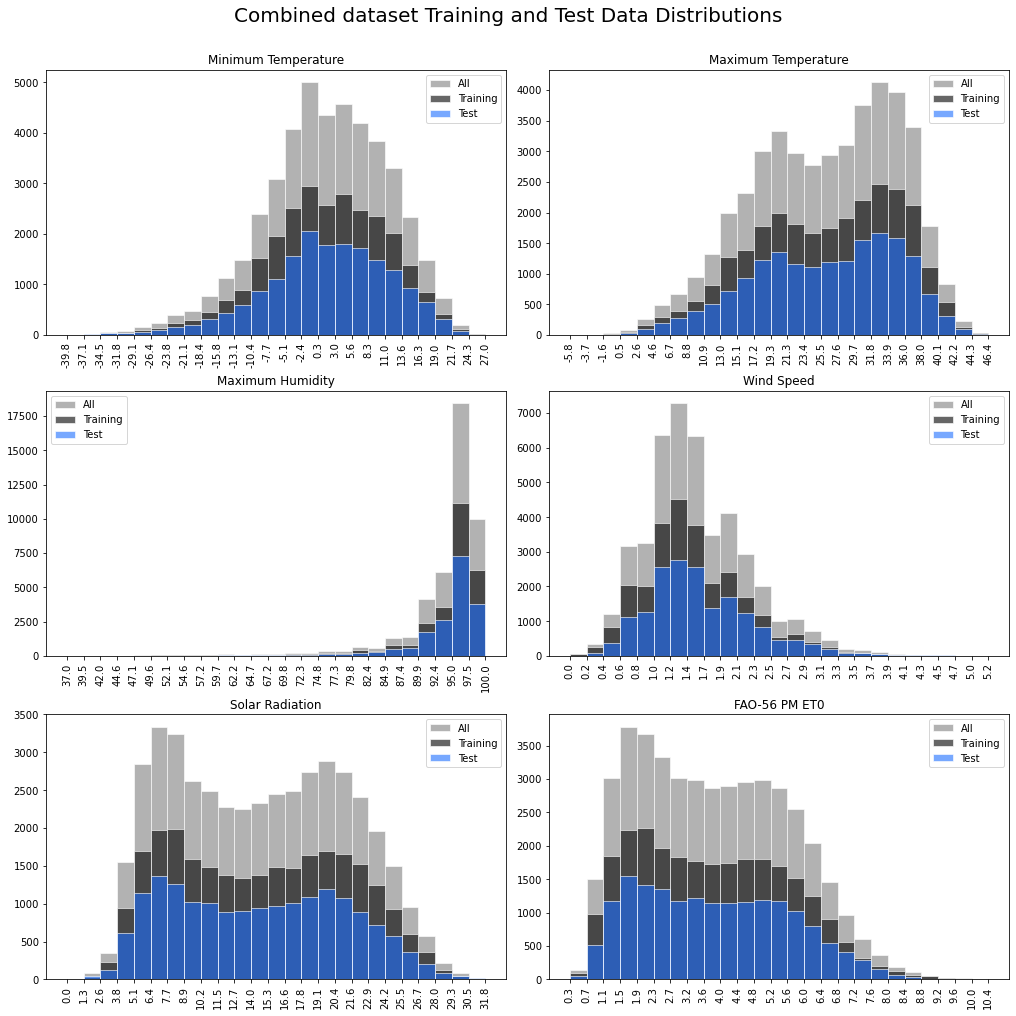

In [45]:
plot_split_distributions(df, et_df, None)

In [43]:
print_split_details(df, et_df, None)

min        max         mean         std
feature   train_test                                               
year      train            1967       2020  1994.932886   11.946262
          test             1967       2020  1994.622951   11.413666
elevation train             2.0     1890.0   698.629978  531.957042
          test              3.0     1758.0   660.803279  551.671761
min_temp  train           -37.9       26.4     1.536387    9.769731
          test            -39.8       27.0     1.739942    9.926989
max_temp  train            -5.8       45.6    26.029482    9.009424
          test             -3.0       46.4     25.96398     8.89006
avg_temp  train           -19.5       33.7    13.782934    9.096726
          test            -18.3       33.3    13.851961    9.116565
max_hum   train            37.0      100.0    93.821812    6.786302
          test             37.0      100.0     93.92344    6.161588
min_hum   train             0.0       79.0    25.379269   12.058004
          test              0.0       76.0    26.291154   12.240526
avg_ws    train             0.0   5.086067     1.542949    0.631406
          test              0.0   5.160862     1.614387    0.646624
avg_rad   train        0.029288  31.543099    14.752415    6.506834
          test         1.209176  31.813991    14.609805    6.464763
Ra        train       12.367639  41.885864    28.617067    9.877109
          test        12.542237  41.882924    28.629941    9.867891
ET0       train        0.321287  10.434616     3.781915    1.818905
          test         0.376238   10.30237     3.812061    1.794025